# NYC Taxi Trip Data 2013

In [1]:
%matplotlib inline

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

plt.style.use('ggplot')

C:\Users\hansh\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Read in data
zf = zipfile.ZipFile('../input/trip_data_1.csv.zip') 
trip_df = pd.read_csv(zf.open('trip_data_1.csv'))

zf = zipfile.ZipFile('../input/trip_fare_1.csv.zip') 
fare_df = pd.read_csv(zf.open('trip_fare_1.csv'))

In [4]:
# Look at the data
print(trip_df.head(3))
print(fare_df.head(3))

                          medallion                      hack_license  \
0  89D227B655E5C82AECF13C3F540D4CF4  BA96DE419E711691B9445D6A6307C170   
1  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   
2  0BD7C8F5BA12B88E0B67BED28BEA73D8  9FD8F69F0804BDB5549F40E9DA1BE472   

  vendor_id  rate_code store_and_fwd_flag      pickup_datetime  \
0       CMT          1                  N  2013-01-01 15:11:48   
1       CMT          1                  N  2013-01-06 00:18:35   
2       CMT          1                  N  2013-01-05 18:49:41   

      dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0  2013-01-01 15:18:10                4                382            1.0   
1  2013-01-06 00:22:54                1                259            1.5   
2  2013-01-05 18:54:23                1                282            1.1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  
0        -73.978165        40.757977         -73.989838  

In [5]:
# Clean column names
fare_cols = fare_df.columns.tolist()
new_fare_cols = []
for col in fare_cols:
    new_fare_cols.append(col.lstrip().rstrip())
fare_df.columns = new_fare_cols

In [6]:
# Concat data
dupe_cols = ['medallion', 'hack_license', 'vendor_id', 'pickup_datetime']
df = pd.concat([trip_df, fare_df.drop(dupe_cols, axis = 1)], axis = 1)
trip_df = None
fare_df = None

In [7]:
# Summary of data
print(df.dtypes)
print(df.describe())


medallion              object
hack_license           object
vendor_id              object
rate_code               int64
store_and_fwd_flag     object
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
trip_time_in_secs       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
payment_type           object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtype: object
             rate_code  passenger_count  trip_time_in_secs    trip_distance  \
count  14776615.000000  14776615.000000    14776615.000000  14776615.000000   
mean          1.034273         1.697372         683.423593         2.770976   
std           0.338771         1.365396         494.406260         3.305923   
min           0.000000         0.000000 

1      10471701
2       1986196
5        920006
3        597485
6        520066
4        280992
0           166
255           1
208           1
9             1
Name: passenger_count, dtype: int64

In [ ]:
df.vendor_id.value_counts()
df.rate_code.value_counts()
df.store_and_fwd_flag.value_counts()


In [51]:
print(df.passenger_count.value_counts()) # found outliers with 0, 9, 208 and 255 passengers
print(100 * df.passenger_count.value_counts() / len(df))

1      10471701
2       1986196
5        920006
3        597485
6        520066
4        280992
0           166
255           1
208           1
9             1
Name: passenger_count, dtype: int64
1      70.866711
2      13.441482
5       6.226094
3       4.043450
6       3.519521
4       1.901599
0       0.001123
255     0.000007
208     0.000007
9       0.000007
Name: passenger_count, dtype: float64


## Wrangling

In [8]:
# Datetime data
datetime_cols = ['pickup_datetime', 'dropoff_datetime']
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

col = 'pickup_datetime'    
df[col.split('_')[0] + '_weeknum'] = df[col].dt.week
df[col.split('_')[0] + '_weekday'] = df[col].dt.dayofweek
df[col.split('_')[0] + '_hour'] = df[col].dt.hour

## EDA

### Univariate Viz

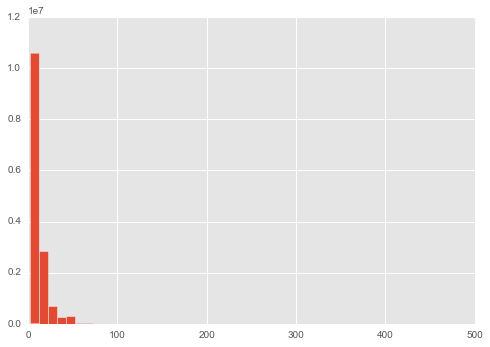

In [22]:
plt.hist(df.fare_amount, 50);

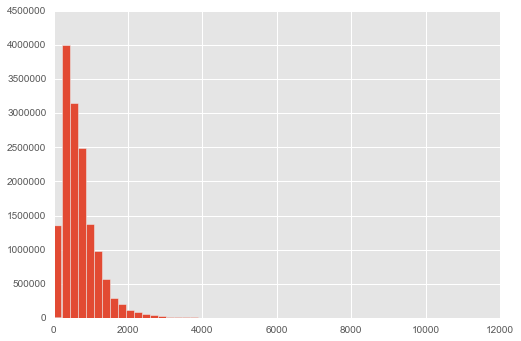

In [21]:
plt.hist(df.trip_time_in_secs, 50);

### Multivariate Viz

C:\Users\hansh\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


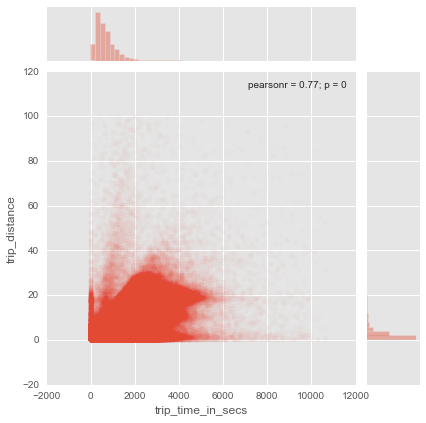

In [32]:
sns.jointplot(x="trip_time_in_secs", y="trip_distance", data=df,  alpha=.01);

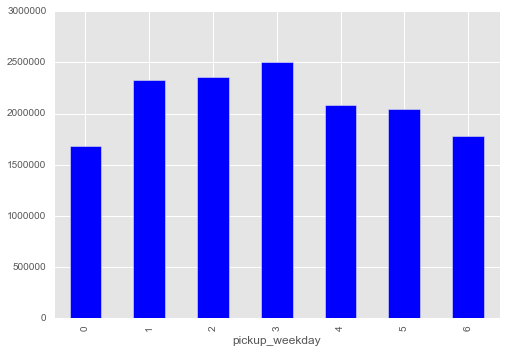

In [39]:
df.groupby(['pickup_weekday'])['medallion'].agg(len).plot(kind='bar');

## Modelling

In [44]:
# Modelling Prep
features = ['trip_time_in_secs', 'trip_distance']
X = df[features].as_matrix()
label = 'fare_amount'
y = df[label].as_matrix()

In [46]:
# Simple Linear Regression
from sklearn import linear_model
linreg = linear_model.LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)

In [47]:
from sklearn import metrics
metrics.r2_score(y, y_pred)  

0.80510472992267157

## Summary

* By far the most common case (71%) of taxi trips has only one passenger
* Pickup and dropoff occurs the most on Thursdays compared to other days of the week
* Mean distance of taxi trips is 2.7 miles
* Mean fare amount is $11.66